Working with embeddings
-------------------------------

OCP works by computing an *embedding*, aka a high dimensional vector representation of the local environment around each atom that the atomic energy is linear in. If two atoms have a similar embedding, then they have similar atomic energies and forces. We can use these embeddings for a variety of applications. For example, in 

    Yang, Y., Liu, M., & Kitchin, J. R. (2022). Neural network embeddings based similarity search method for atomistic systems. Digital Discovery, 1(5), 636–644. http://dx.doi.org/10.1039/d2dd00055e

We used them to search for similar atomic structures.

We can use them for diagnostic purposes, or clustering.

In this example, we patch the GemNetOC model to save the embeddings so you can easily access them. This requires two changes. The first is in the GemNetOC model where the embeddings are saved, and the second is in the OCPCalculator to retrieve them.

We provide 5 different kinds of embeddings:

1. 'h' - This is an early block in the embedding calculation. You get the h-embedding for each atom
2. 'h sum' - This is an early block in the embedding calculation. You get the h-embedding summed over each atom
3. 'x_E' - The atomic energy is linear in this, returned for each atom
4. 'x_E sum' - summed over atoms
5. 'x_F sum' - This is related to the forces

In principle other models could be adapted in a similar way. See [embedding-monkeypatch.ipynb](./embedding-monkeypatch.ipynb) for details on the patch. We simply run this notebook below to load it.

The OCP project is still under active development, and it is not yet clear what the best way to access these embeddings are, so this code is not yet part of the main development branch. This code was adapted from a branch at https://github.com/Open-Catalyst-Project/ocp/blob/gnoc-embeddings.

In [1]:
%run embedding-monkeypatch.ipynb
%run ../ocp-tutorial.ipynb

# A diagnostic example

Here we will look at an equation of state for bulk fcc Cu.

In [2]:
import matplotlib.pyplot as plt
from ase import Atom, Atoms
import numpy as np

In [3]:
%%capture
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import os
cp = checkpoint = get_checkpoint('GemNet-OC OC20+OC22')
calc = OCPCalculator(checkpoint_path=cp)

## Bulk Cu equation of state example

Here we simply compute an equation of state by varying the lattice constant. You will see a small unphysical feature near 3.7 angstroms. We will investigate why that happens.

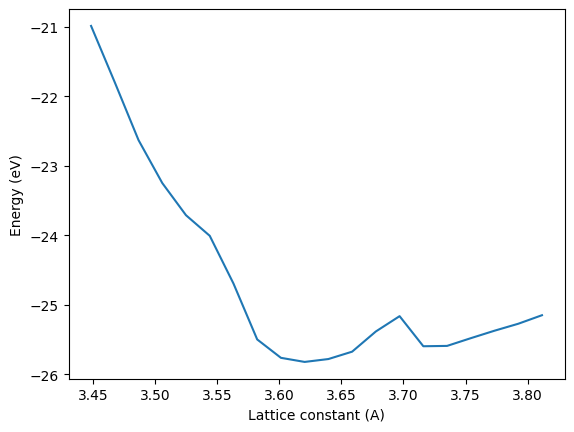

In [4]:
#calc.trainer._unwrapped_model.return_embedding = False
a0 = 3.63
E = []

LC = np.linspace(0.95 * a0, 1.05 * a0, 20)

for a in LC:
    atoms = Atoms([Atom('Cu', (0, 0, 0))],
                  cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                                           [0.0, 1.0, 1.0],
                                           [1.0, 0.0, 1.0]]),
                 pbc=True)
    atoms = atoms.repeat((2, 2, 2))
    atoms.set_tags(np.ones(len(atoms)))
    atoms.set_calculator(calc)
    E += [atoms.get_potential_energy()]
    
plt.plot(LC, E)
plt.xlabel('Lattice constant (A)')
plt.ylabel('Energy (eV)');

Something is a little off in this equation of state, there is an unphysical bump in it. We now rerun this and get the embeddings. You simply call the `calc.embed` method. We need a reference configuration to compare too. We choose a lattice constant of 3.63 angstroms and compute three different embeddings.

In [5]:
a0 = 3.63
atoms = Atoms([Atom('Cu', (0, 0, 0))],
               cell=0.5 * a0 * np.array([[1.0, 1.0, 0.0],
                                          [0.0, 1.0, 1.0],
                                          [1.0, 0.0, 1.0]]),
            pbc=True)
atoms = atoms.repeat((2, 2, 2))
atoms.set_tags(np.ones(len(atoms)))
atoms.calc = calc

out = calc.embed(atoms)

x1, x2, x3 = out['h sum'], out['x_E sum'], out['x_F sum']

Next, we loop over a grid of lattice constants, and we compare the cosine similarity of the embeddings for each one to the reference embeddings above. A similarity of 1 means they are the same, and as the similarity decreases it means the embbedings are more and more different (and so is the energy).

In [6]:
E = []

LC = np.linspace(0.95 * a0, 1.05 * a0, 200)
cossim1, cossim2, cossim3 = [], [], []
for a in LC:
    atoms = Atoms([Atom('Cu', (0, 0, 0))],
                  cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                                           [0.0, 1.0, 1.0],
                                           [1.0, 0.0, 1.0]]),
                 pbc=True)
    atoms = atoms.repeat((2, 2, 2))
    atoms.set_tags(np.ones(len(atoms)))

    out = calc.embed(atoms)
    
    cossim1.append(torch.cosine_similarity(x1, out["h sum"]).item())
    cossim2.append(torch.cosine_similarity(x2, out["x_E sum"]).item())
    cossim3.append(torch.cosine_similarity(x3, out["x_F sum"]).item())
    E += [out['energy']]

Now we plot the results.

/opt/conda/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/conda/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


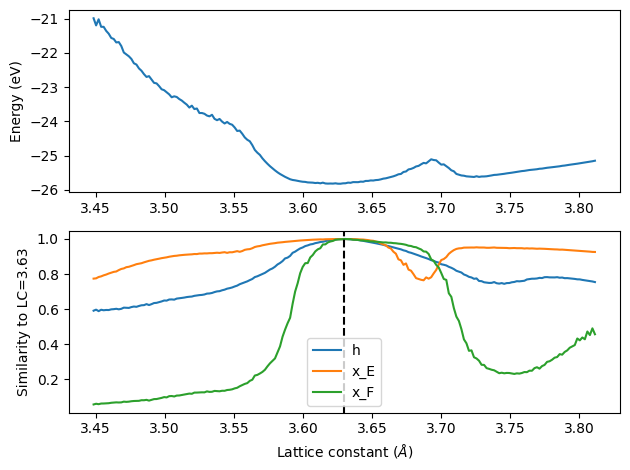

In [7]:
_, (ax1, ax2) = plt.subplots(2, 1)    

ax1.plot(LC, E)
ax1.set_ylabel('Energy (eV)')
ax2.plot(LC, cossim1, label="h")
ax2.plot(LC, cossim2, label="x_E")
ax2.plot(LC, cossim3, label="x_F")
ax2.axvline(3.63, c='k', ls='--')
ax2.legend()


plt.xlabel('Lattice constant ($\AA$)')
plt.ylabel(f'Similarity to LC={a0}')

plt.tight_layout()

We can see that near the minimum the different embeddings are all quite similar. But, near the unphysical peak, the x_E embedding shows a significant deviation. The atomic energy is linear in this embedding, which is why we see the peak. This means the embedding is not sufficiently trained in this region, and fine-tuning should be considered with data in that region.

# A clustering example

We use this example to show that we can cluster structures by embedding similarities. We compute 20 configurations of an octahedral nanoparticle, and 20 configurations of a bulk Cu structure. We accumulate these into a list of vectors. We use 20 configurations from the nanoparticle, and 40 configurations for the bulk. That will make it easy to see which clusters are which later.

In [8]:
from ase.build import bulk
from ase.cluster import Octahedron

calc.trainer._unwrapped_model.return_embedding = True

embeddings = []
labels = []

oct = Octahedron('Cu', 2)
oct.set_tags(np.ones(len(oct)))

for i in range(20):
    oct.rattle(0.01)
    embeddings += [calc.embed(oct)['x_E sum'][0].numpy()]
    labels += [0]

In [9]:
b = bulk('Cu')
b = b.repeat((2, 2, 2))
b.set_tags(np.ones(len(b)))

for i in range(40):
    b.rattle(0.01)
    embeddings += [calc.embed(b)['x_E sum'][0].numpy()]
    labels += [1]

In [10]:
embeddings = np.array(embeddings)
embeddings.shape

(60, 256)

In [11]:
%%capture
! pip install umap-learn

Now we use a tool like umap. This will take the 40 vectors with 256 dimensions each, and reduce these to two dimennsions where similar embeddings remain close together. You should see two clusters. The one labeled 1 with 40 points is the bulk set.

In [12]:
import umap

um = umap.UMAP(random_state=42).fit_transform(embeddings)

/opt/conda/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

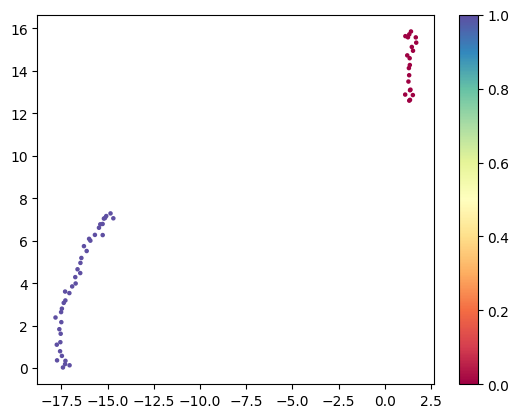

In [13]:
plt.scatter(*um.T, c=labels, s=5, cmap='Spectral')
plt.colorbar();

## Clustering individual atoms

If we get the atomic embeddings, we can cluster them by similarity too. Here we look at how many kinds of atoms there are in an Octahedron cluster and bulk system. We color code the clusters by the atomic energy of each atom. 

/opt/conda/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4411: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.asanyarray(c, dtype=float)


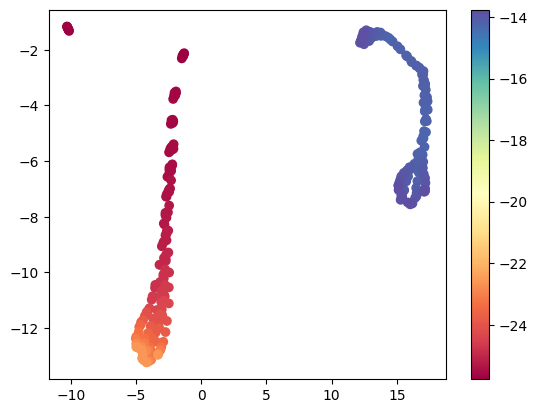

In [14]:
embeddings = []
labels = []
energies = []

oct = Octahedron('Cu', 2)
oct.set_tags(np.ones(len(oct)))

for i in range(20):
    oct.rattle(0.01)
    out = calc.embed(oct)
    for a in out['h'][0]:
        embeddings += [a.numpy()]
        labels += [0]
        energies += [out['energy']]

b = bulk('Cu')
b = b.repeat((2, 2, 2))
b.set_tags(np.ones(len(b)))

for i in range(20):
    b.rattle(0.01)
    out = calc.embed(b)
    for a in out['h'][0]:
        embeddings += [a.numpy()]
        labels += [1]
        energies += [out['energy']]
        
embeddings = np.array(embeddings)

um = umap.UMAP(random_state=42).fit_transform(embeddings)
plt.scatter(*um.T, c=energies, cmap='Spectral')
plt.colorbar();


You can see from this there are roughly three kinds of atoms. One is bulk like, with the lowest energy (the dark red points), the second is also lower in energy (the reddish-orange points), and the others are surface atoms, with higher energies (the bluish points). 

# A simple vector search example

In this example we perform a simple vector search in the embedding space. We use [vdict](https://github.com/whitead/vdict) for the vector database here. 

Our database is very small, it only contains embeddings for ethanol and ethane. After we make it, we search the database to find the atom that is closest to the C atom in methanol. 

Note in this example, we have to tag all the atoms with 1 for GemnetOC to work.

In [15]:
! pip install vdict 2&>1 /devnull

Here we set up the simple database. Each row, or entry, is the actual embedding vector for an atom. That is the key that points to the atom index and the atoms object. I use cosine similarity here. If you use the default (l2) then you may not find anything close enough.

In [17]:
import numpy as np
from ase.build import molecule
from vdict import vdict

data = vdict(space='cosine')

ethanol = molecule('CH3CH2OH')
ethanol.set_tags(np.ones(len(ethanol)))
ethanol_emb = calc.embed(ethanol)

methane = molecule('C2H6')
methane.set_tags(np.ones(len(methane)))
methane_emb = calc.embed(methane)

for i, atom in enumerate(ethanol):
    data[ethanol_emb['x_E'][0][i].numpy()] = [i, ethanol]
    
for i, atom in enumerate(methane):
    data[methane_emb['x_E'][0][i].numpy()] = [i, methane]

Now we construct our "query". We inspect the Atoms object, see that the C atom is the first one, and then extract the embedding for that atom and save it in a variable.

In [18]:
methanol = molecule('CH3OH')
methanol.set_tags(np.ones(len(methanol)))
methanol_emb = calc.embed(methanol)
methanol

Atoms(symbols='COH4', pbc=False, tags=...)

In [19]:
query = methanol_emb['x_E'][0][0].numpy()

We run our search with the syntax like a dictionary. It returns the closest found match.

In [20]:
i, found = data[query]
i, found[i]

(1, Atom('C', [0.0, 0.559462, 0.0], tag=1, index=1))

In [24]:
for ind, atom in enumerate(found):
    print(ind, atom)

0 Atom('C', [1.168181, -0.400382, 0.0], tag=1, index=0)
1 Atom('C', [0.0, 0.559462, 0.0], tag=1, index=1)
2 Atom('O', [-1.190083, -0.227669, 0.0], tag=1, index=2)
3 Atom('H', [-1.946623, 0.381525, 0.0], tag=1, index=3)
4 Atom('H', [0.042557, 1.207508, 0.886933], tag=1, index=4)
5 Atom('H', [0.042557, 1.207508, -0.886933], tag=1, index=5)
6 Atom('H', [2.115891, 0.1448, 0.0], tag=1, index=6)
7 Atom('H', [1.128599, -1.037234, 0.885881], tag=1, index=7)
8 Atom('H', [1.128599, -1.037234, -0.885881], tag=1, index=8)


This finds the second carbon in the molecule. That is the one that is closest to the oxygen atom. That means it is more similar to the methanol carbon than the first carbon in ethanol which is a CH3, but it is farther from the oxygen atom.

This is pretty remarkable! The query had no explicit information about C in it other than the embedding for that atom, and it found another atom that was similar.

In [25]:
found.get_distance(0, 2), found.get_distance(1, 2)

(2.364580062942467, 1.426840130515679)

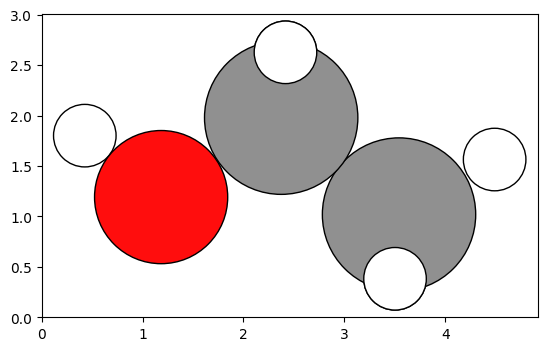

In [26]:
from ase.visualize.plot import plot_atoms
plot_atoms(found);